In [2]:
import numpy as np
import pandas as pd

import os
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data\gender_submission.csv
./data\test.csv
./data\train.csv


In [3]:
train_data = pd.read_csv(".\\data\\train.csv",index_col = "PassengerId")
test_data = pd.read_csv(".\\data\\test.csv",index_col = "PassengerId")

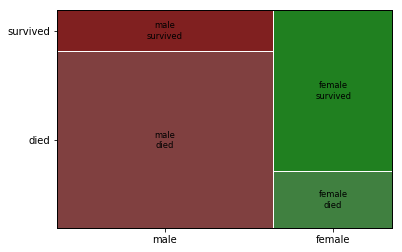

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.mosaicplot import mosaic

survived_mapping = {0:'died',1:'survived'}
train_data['SurvivedText'] = train_data['Survived'].map(survived_mapping)

mosaic(train_data, ['Sex', 'SurvivedText'])
plt.show()

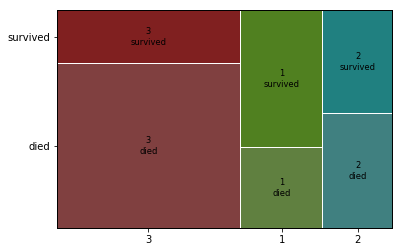

In [5]:
mosaic(train_data, ['Pclass', 'SurvivedText'])
plt.show()

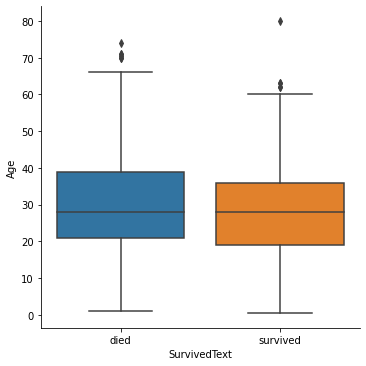

In [6]:
sns.catplot(x="SurvivedText", y="Age", kind="box", data=train_data);

In [7]:
train_data = train_data.drop(columns=['SurvivedText'])

In [8]:
features = ['Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']

def print_null_values(dataset,features):
    row, column = dataset.shape 
    for feature in features:
        values = dataset[feature].count()
        missing_values = dataset[feature].isnull().sum()
        nan_values = dataset[feature].isna().sum()
        perc = (values / row) * 100
        print("{0} {1} {2} {3:.2f}%".format(feature,values,missing_values,perc))
    
print_null_values(train_data,features)

Pclass 891 0 100.00%
Name 891 0 100.00%
Sex 891 0 100.00%
Age 714 177 80.13%
SibSp 891 0 100.00%
Parch 891 0 100.00%
Ticket 891 0 100.00%
Fare 891 0 100.00%
Cabin 204 687 22.90%
Embarked 889 2 99.78%


In [9]:
print_null_values(test_data,features)

Pclass 418 0 100.00%
Name 418 0 100.00%
Sex 418 0 100.00%
Age 332 86 79.43%
SibSp 418 0 100.00%
Parch 418 0 100.00%
Ticket 418 0 100.00%
Fare 417 1 99.76%
Cabin 91 327 21.77%
Embarked 418 0 100.00%


In [10]:
sex_mapping = {'female':1,'male':0}
train_data['Sex'] = train_data['Sex'].map(sex_mapping)
test_data['Sex'] = test_data['Sex'].map(sex_mapping)

In [11]:
train_data[['Sex','Pclass', 'Survived']].groupby(['Sex','Pclass']).mean().sort_values("Survived", ascending = True)

Survived
Sex Pclass          
0   3       0.135447
    2       0.157407
    1       0.368852
1   3       0.500000
    2       0.921053
    1       0.968085

In [12]:
def extract_title(dataset):
    dataset["Title"] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    dataset['Title'] = dataset['Title'].replace('Lady', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Countess', 'Mrs')
    dataset['Title'] = dataset['Title'].replace('Sir', 'Mrs')
    dataset['Title'] = dataset['Title'].fillna('None')


extract_title(train_data)
extract_title(test_data)

train_data['Title'].value_counts()

Mr          517
Miss        186
Mrs         128
Master       40
Dr            7
Rev           6
Major         2
Col           2
Jonkheer      1
Don           1
Capt          1
Name: Title, dtype: int64

In [13]:
frequent_titles = train_data['Title'].value_counts()[:6].index.tolist()
train_data['Title'] = train_data['Title'].apply(lambda x: x if x in frequent_titles else 'Rare')
test_data['Title'] = test_data['Title'].apply(lambda x: x if x in frequent_titles else 'Rare')

In [14]:
train_data['Title'].value_counts()

Mr        517
Miss      186
Mrs       128
Master     40
Dr          7
Rare        7
Rev         6
Name: Title, dtype: int64

In [15]:
train_data[['Title', 'Survived']].groupby(['Title'], as_index=False).mean().sort_values("Survived", ascending = True)

,Title,Survived
6,Rev,0.000000
3,Mr,0.156673
5,Rare,0.285714
0,Dr,0.428571
1,Master,0.575000
2,Miss,0.704301
4,Mrs,0.796875


In [16]:
title_map = {'Rev':1,'Mr':2,'Rare':3,'Dr':4,'Master':5,'Miss':6,'Mrs':7}

def map_title(dataset):
    dataset['TitleMap'] = dataset['Title'].map(title_map)
    dataset['TitleMap'] = dataset['TitleMap'].fillna(0).astype('int')


map_title(train_data)
map_title(test_data)

In [17]:
def extract_surname(dataset):
    dataset["Surname"] = dataset.Name.str.extract('(\w+),', expand=False)
    dataset["Surname"] = dataset.Surname.str.lower()
    dataset['Surname'] = dataset['Surname'].replace(',', '')
    
extract_surname(train_data)
extract_surname(test_data)   

In [18]:
import re
pattern = r'\d+'

def ticket_info(dataset):
    for index, row in dataset.iterrows():
        ticket = row['Ticket']
        matches = re.findall(pattern, ticket)
        filtered = []
        for match in matches:
            if match:
                match = match.replace(".","").replace("/","").strip()
                filtered.append(match)
            else:
                filtered.append('X')
                
        if len(filtered) == 0:
            filtered.append('X')
    
        dataset.at[index,'Ticket'] = filtered[0]

ticket_info(train_data)
ticket_info(test_data)

In [19]:
family_cols = ["Surname","Ticket"]

train_family = train_data[family_cols]
test_family = test_data[family_cols]

total_family = pd.concat([train_family,test_family])

families = total_family.value_counts()

families




Surname    Ticket
sage       2343      11
goodwin    2144       8
asplund    347077     7
andersson  347082     7
rice       382652     6
                     ..
hagardon   3          1
hagland    65303      1
           65304      1
hale       250653     1
zimmerman  315082     1
Length: 1020, dtype: int64

In [20]:
surname_map = train_data.groupby(['Surname','Ticket'])['Survived'].agg(['count', 'mean'])
surname_map

,,count,mean
Surname,Ticket,,
abbing,5547,1,0.0
abbott,2673,2,0.5
abelson,3381,2,0.5
adahl,7076,1,0.0
adams,341826,1,0.0
...,...,...,...
yousif,2647,1,0.0
yousseff,2627,1,0.0
yrois,248747,1,0.0


In [21]:
#smooth mean
m=3

mean_survived = train_data['Survived'].mean()
counts = surname_map['count']
means = surname_map['mean']

smooth = (counts * means + m * mean_survived) / (counts + m)


def family_info(dataset):
    for index, row in dataset.iterrows():
        surname = row['Surname']
        ticket = row['Ticket']
        
        try:
            survived = smooth[surname,ticket]
        except:
            survived = mean_survived
        
        dataset.at[index,'FamilySurvived'] = survived
        

family_info(train_data) 
family_info(test_data) 

In [22]:
train_data = train_data.drop(['Name'], axis=1)
test_data = test_data.drop(['Name'], axis=1)

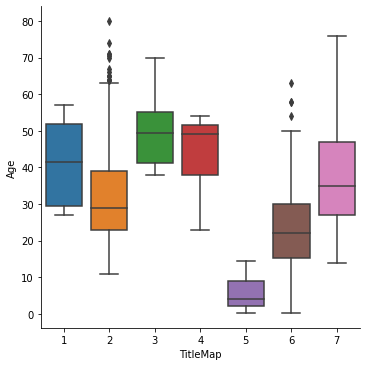

In [23]:
age_train_data = train_data.dropna(subset = ["Age"])
age_test_data = test_data.dropna(subset = ["Age"])

age_all_data = pd.concat([age_train_data, age_test_data])

sns.catplot(x="TitleMap", y="Age", kind="box", data=age_all_data);

In [24]:
grouped_ages = age_all_data[['TitleMap','Pclass','Age']].groupby(['TitleMap','Pclass']).median()
median_ages = age_all_data['Age'].median()

def impute_age(dataset):
    for index, row in dataset.iterrows():
        title = row['TitleMap']
        pclass = row['Pclass']
        age = row['Age']
        if pd.isna(age):
            try:
                age = grouped_ages[title,pclass]
            except:
                age = median_ages
            
            dataset.at[index,'Age'] = age


train_data['AgeImputed'] = train_data['Age'].isnull().astype('int')
test_data['AgeImputed'] = test_data['Age'].isnull().astype('int')

impute_age(train_data)
impute_age(test_data)


In [25]:
def age_band(dataset,bins = 5):
    labels = range(bins)
    return pd.cut(dataset['Age'], bins=bins,labels=labels)

In [26]:
train_data['AgeBand'] = age_band(train_data,6).astype('int')
test_data['AgeBand'] = age_band(test_data,6).astype('int')

In [27]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1
test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1

In [28]:
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype('int')
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype('int')

In [29]:
train_data[['Embarked', 'Survived']].groupby(['Embarked'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Embarked,Survived
0,C,0.553571
1,Q,0.389610
2,S,0.336957


In [30]:
freq_port = train_data.Embarked.dropna().mode()[0]
train_data['Embarked'] = train_data['Embarked'].fillna(freq_port)

In [31]:
train_data[['Pclass', 'Fare']].groupby(['Pclass'], as_index=False).median().sort_values(by='Pclass', ascending=False)

,Pclass,Fare
2,3,8.0500
1,2,14.2500
0,1,60.2875


In [32]:
fares = [60.2875,14.2500,8.0500]

In [33]:
def impute_fares(dataset,fares):
    for clazz in range(1, 4):
        dataset.loc[(dataset.Fare.isnull()) & (dataset.Pclass == clazz),'Fare'] = fares[clazz-1]

In [34]:
impute_fares(test_data,fares)

In [35]:
def fare_band(dataset,bins = 5):
    labels = range(bins)
    return pd.cut(dataset['Fare'], bins=bins,labels=labels)

train_data['FareBand'] = fare_band(train_data,6).astype('int')
test_data['FareBand'] = fare_band(test_data,6).astype('int')

In [36]:
def position_band(dataset):
    labels = ['front','medium','rear']
    return pd.cut(dataset['Position'], bins=3,labels=labels)


train_data['Deck'] = train_data.Cabin.str.extract('([A-Za-z]+)', expand=False)
test_data['Deck'] = test_data.Cabin.str.extract('([A-Za-z]+)', expand=False)


train_data['Position'] = train_data.Cabin.str.extract('([0-9]+)', expand=False).apply(pd.to_numeric, errors='coerce')
test_data['Position'] = test_data.Cabin.str.extract('([0-9]+)', expand=False).apply(pd.to_numeric, errors='coerce')

train_data['Position'] = position_band(test_data)
test_data['Position'] = position_band(test_data)

train_data['HasCabin'] = train_data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)
test_data['HasCabin'] = test_data["Cabin"].apply(lambda x: 0 if type(x) == float else 1)


In [37]:
train_data = train_data.drop(['Ticket', 'Cabin','Title','Surname'], axis=1)
test_data = test_data.drop(['Ticket', 'Cabin','Title','Surname'], axis=1)

In [38]:
train_data = pd.get_dummies(train_data)
test_data =  pd.get_dummies(test_data)

In [39]:
train_data['LogFare'] = np.log10(train_data['Fare'] + 1)
test_data['LogFare'] = np.log10(test_data['Fare'] + 1)

In [40]:
from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()

train_data['Age'] = mms.fit_transform(train_data["Age"].values.reshape(-1, 1))
test_data['Age'] = mms.transform(test_data["Age"].values.reshape(-1, 1))

In [41]:
train_data = train_data.drop(['Fare'], axis=1)
test_data = test_data.drop(['Fare'], axis=1)

In [42]:
train_data

,Survived,Pclass,Sex,Age,SibSp,Parch,TitleMap,FamilySurvived,AgeImputed,AgeBand,...,Deck_C,Deck_D,Deck_E,Deck_F,Deck_G,Deck_T,Position_front,Position_medium,Position_rear,LogFare
PassengerId,,,,,,,,,,,,,,,,,,,,,
1,0,3,0,0.271174,1,0,2,0.287879,0,1,...,0,0,0,0,0,0,0,0,0,0.916454
2,1,1,1,0.472229,1,0,7,0.537879,0,2,...,1,0,0,0,0,0,0,0,0,1.859038
3,1,3,1,0.321438,0,0,6,0.537879,0,1,...,0,0,0,0,0,0,0,0,0,0.950608
4,1,1,1,0.434531,1,0,7,0.430303,0,2,...,1,0,0,0,0,0,0,0,0,1.733197
5,0,3,0,0.434531,0,0,2,0.287879,0,2,...,0,0,0,0,0,0,0,0,0,0.956649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,0.334004,0,0,1,0.287879,0,2,...,0,0,0,0,0,0,0,0,0,1.146128
888,1,1,1,0.233476,0,0,6,0.537879,0,1,...,0,0,0,0,0,0,0,0,0,1.491362
889,0,3,1,0.346569,1,2,6,0.230303,1,2,...,0,0,0,0,0,0,0,0,0,1.388279


In [43]:
X_train = train_data.copy()
y_train = X_train.pop('Survived')

X_test = test_data.copy()

In [44]:
from sklearn.ensemble import RandomForestClassifier

treshold = 0.01


forest = RandomForestClassifier(n_estimators = 500)
forest.fit(X_train,y_train)

importances = forest.feature_importances_
indexes = np.argsort(importances)[::-1]

columns = []


for i,f in enumerate(indexes):
    importance = importances[f]
    if importance >= treshold:
        column = X_train.columns[f]
        columns.append(column)
        print("{0:2} {1:30} {2:.2f}".format(i+1,column,importances[f]))
        

 1 FamilySurvived                 0.57
 2 TitleMap                       0.12
 3 Sex                            0.09
 4 LogFare                        0.05
 5 Age                            0.03
 6 Pclass                         0.03
 7 FamilySize                     0.02
 8 HasCabin                       0.02
 9 SibSp                          0.01
10 AgeBand                        0.01


In [46]:
X_train = X_train[columns]
X_test = X_test[columns]

In [72]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0]

param_grid = [{'C': param_range, 
               'kernel': ['linear']},
              {'C': param_range, 
               'gamma': param_range, 
               'kernel': ['rbf']}]

model = SVC()

gs = GridSearchCV(estimator=model, 
                  param_grid=param_grid, 
                  scoring='accuracy', 
                  refit=True,
                  cv=10,
                  n_jobs=-1)

gs = gs.fit(X_train, y_train)

print("L'accuratezza del modello è {0:.2f}%".format(gs.best_score_ * 100))
print(gs.best_params_)

L'accuratezza del modello è 98.09%
{'C': 5.0, 'kernel': 'linear'}


In [73]:
predictions = gs.predict(X_test)

In [74]:
#test_data = test_data.reset_index()
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
output.to_csv('my_submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


Submission 0.79